# Excercise on spatio-temporal aggregation and exploration of multiple (spatial) time series

The goals of this exercise are:
* Get acquainted with two types of spatio-temporal data: spatial events and spatial time series.
* Get experience in performing spatio-temporal aggregation of events, including division of space and time. See how spatial time series are obtained through aggregation of spatial events.
* Understand two complementary views of spatial time series and possible ways to analyse the data with each of these views.

For a more detailed description, refer to the [exercise description document](exercise_description.pdf). 

A video demonstrating the analytical procedure as implemented in V-Analytics is: <a href="events_aggregation_STS_clustering.mp4">events_aggregation_STS_clustering.mp4</a><br>

If <i>folium</i> is not installed on your computer, execute the following command <pre>conda install -c conda-forge folium tornado==4.5.3</pre>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import folium as fm
from shapely.geometry import Polygon

from math import radians, asin, sqrt, sin, cos, log, log10

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from collections import Counter

from IPython.core.display import Markdown, display, HTML

## Helper functions

In [2]:
# Use in-line date string conversion/parsing, it is significantly more effective than applying pd.to_datetime() on a dataframe column post-loading
def dt_parse(timestamp_str):
    return pd.to_datetime(timestamp_str, format='%Y%m%d %H:%M:%S', errors='coerce')

def printmd(string):
    display(Markdown(string))
    
# 12-step qualitative color scale, courtesy of www.colorbrewer2.org
clust_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

# 9-step continuous ordered color scale "OrdRd", courtesy of www.colorbrewer2.org
cb2_ordrd = ['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000']
# Same color scale, as rgb tuples for easier interpolation
cb2_ordrd_rgb = [(255,247,236), (254,232,200), (253,212,158), (253,187,132), (252,141,89), (239,101,72), (215,48,31), (179,0,0), (127,0,0)]

## Configure notebook appearance

In [3]:
# setup the screen display
%matplotlib inline
pd.options.display.max_columns = 200
#display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("""<style>
  .rendered_html tr, .rendered_html th,  .rendered_html td {   text-align: right; }  
  .rendered_html :first-child {   text-align: left; } 
  .rendered_html :last-child {   text-align: left; }
  </style>"""))

# Tweak default output of pyplots
screen_dpi = plt.rcParams['figure.dpi']
# 'figsize' is in inches, so convert desired default figure size in pixels into inches using the given sceen dpi 
plt.rcParams["figure.figsize"] = [800/screen_dpi,600/screen_dpi]

## Load the raw data

In [4]:
np.random.seed(123)

events = pd.read_csv('lightnings_13_30-17_30.csv', sep=',', decimal='.', header=0, index_col='id', parse_dates=['date time'], date_parser=dt_parse)
events.describe()

,latitude,longitude,Height,Type,Amplitude,2D_Error,minute of the day
count,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000
mean,51.011351,5.113726,4.642635,1.498510,-2.191047,0.175029,957.996239
std,0.341999,0.827666,5.261670,0.500002,11.388274,0.265534,54.490175
min,50.000000,2.966000,0.000000,1.000000,-151.600000,0.035000,810.000000
25%,50.774800,4.525950,0.000000,1.000000,-7.400000,0.057000,922.000000
50%,50.926950,5.063300,0.000000,1.000000,-4.800000,0.089000,961.000000
75%,51.247400,5.748900,9.400000,2.000000,5.500000,0.198000,1000.000000
max,52.198400,7.090500,39.900000,2.000000,274.300000,8.773000,1050.000000


In [5]:
events.head()

,date time,latitude,longitude,Height,Type,Amplitude,2D_Error,minute of the day
id,,,,,,,,
6249,2011-08-18 13:30:01,50.9498,2.9702,0.0,1,-20.4,0.045,810
6250,2011-08-18 13:30:01,50.9803,2.9733,0.0,1,-17.0,0.043,810
6251,2011-08-18 13:30:02,51.1219,3.1114,0.0,1,-9.7,0.051,810
6252,2011-08-18 13:30:04,50.7627,3.9201,6.5,2,16.4,0.071,810
6253,2011-08-18 13:30:04,50.7645,3.9215,10.2,2,5.0,0.171,810


# Tasks

Study the spatio-temporal distribution of the strike events and describe how the thunderstorm evolved and moved over Europe by applying spatio-temporal aggregation to the events and analysing the resulting spatial time series.

### Spatio-temporal aggregation of the events
You partition the territory using a regular rectangular grid with the cell size roughly 20x20 km.
Grid parameters: 
* 2.93 <= longitude <= 7.2287636 divided by 15 (number of columns)
* 49.95 <= latitude <= 52.28824 divided by 13 (number of rows)

For the event counts by time intervals use the length of 10 minutes, i.e., you divide the time range of the data from 13:30 till 17:30 into 24 equal intervals. For your convenience (to save your efforts on transforming strings to datetime format and dividing the time into intervals), we have created an attribute “minute of the day” with values ranging from 810 to 1050. You can divide the events into time bins based on the values of this attribute.

#### Grid parameters

In [6]:
lon_range = (2.93, 7.2287636)
lon_cells = 15

lat_range = (49.95, 52.28824)
lat_cells = 13

# mod = minute-of-day
mod_range = (810, 1050)
mod_steps = 24

### Build GeoJSON object for visualization of ST-aggregates

In [7]:
lon_incr = (lon_range[1] - lon_range[0]) / lon_cells
lat_incr = (lat_range[1] - lat_range[0]) / lat_cells
x0, y0 = lon_range[0], lat_range[0]

cell_ids = []
grid_cells = []
for c in range(lon_cells):
    x1 = x0 + lon_incr
    for r in range(lat_cells):
        y1 = y0 + lat_incr
        grid_cells.append(Polygon([(x0,y0),(x0,y1),(x1,y1),(x1,y0)]))
        cell_ids.append('{:02d}_{:02d}'.format(c, r))
        y0 = y1
    x0 = x1
    y0 = lat_range[0]


### Assign grid cell and time interval  indices to events

In [8]:
events['grid_x']   = np.floor((events['longitude'] - lon_range[0]) / (lon_range[1] - lon_range[0]) * lon_cells).astype(int)
events['grid_y']   = np.floor((events['latitude']  - lat_range[0]) / (lat_range[1] - lat_range[0]) * lat_cells).astype(int)
# The cell_id column will be used to link our aggregate data to the grid GeoJSON object for plotting
events['cell_id']  = events[['grid_x','grid_y']].apply(lambda x: '{:02d}_{:02d}'.format(x.grid_x, x.grid_y), axis=1)
events['interval'] = np.floor((events['minute of the day']  - mod_range[0]) / (mod_range[1] - mod_range[0]) * mod_steps).astype(int) # Note this results in 25 intervals as timestamps==17:30:00 are inside interval [17:30:00, 17:39:59]

In [9]:
events.head()

,date time,latitude,longitude,Height,Type,Amplitude,2D_Error,minute of the day,grid_x,grid_y,cell_id,interval
id,,,,,,,,,,,,
6249,2011-08-18 13:30:01,50.9498,2.9702,0.0,1,-20.4,0.045,810,0,5,00_05,0
6250,2011-08-18 13:30:01,50.9803,2.9733,0.0,1,-17.0,0.043,810,0,5,00_05,0
6251,2011-08-18 13:30:02,51.1219,3.1114,0.0,1,-9.7,0.051,810,0,6,00_06,0
6252,2011-08-18 13:30:04,50.7627,3.9201,6.5,2,16.4,0.071,810,3,4,03_04,0
6253,2011-08-18 13:30:04,50.7645,3.9215,10.2,2,5.0,0.171,810,3,4,03_04,0


In [10]:
events.describe()

,latitude,longitude,Height,Type,Amplitude,2D_Error,minute of the day,grid_x,grid_y,interval
count,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000,53702.000000
mean,51.011351,5.113726,4.642635,1.498510,-2.191047,0.175029,957.996239,7.111281,5.412759,14.346952
std,0.341999,0.827666,5.261670,0.500002,11.388274,0.265534,54.490175,2.905637,1.920094,5.451667
min,50.000000,2.966000,0.000000,1.000000,-151.600000,0.035000,810.000000,0.000000,0.000000,0.000000
25%,50.774800,4.525950,0.000000,1.000000,-7.400000,0.057000,922.000000,5.000000,4.000000,11.000000
50%,50.926950,5.063300,0.000000,1.000000,-4.800000,0.089000,961.000000,7.000000,5.000000,15.000000
75%,51.247400,5.748900,9.400000,2.000000,5.500000,0.198000,1000.000000,9.000000,7.000000,19.000000
max,52.198400,7.090500,39.900000,2.000000,274.300000,8.773000,1050.000000,14.000000,12.000000,24.000000


### Build time series per grid cell

In [11]:
# Derive possible time series by aggregating over cells x intervals
agg_func = {
    'grid_x':'first',
    'grid_y':'first',
    'id':'count',
    'Height':['mean','median'],
    'Type':'nunique',
    'Amplitude':['median','mean','std']
}
st_aggregates = events.reset_index(drop=False)[['cell_id','grid_x','grid_y','interval','id','Height','Type','Amplitude']].groupby(['cell_id','interval']).agg(agg_func)

# Flatten hierarchical column names
st_aggregates.columns = ["_".join(x) for x in st_aggregates.columns.ravel()]

# Rename columns to be more expressive
st_aggregates.rename(columns={'id_count':'Count', 'Type_nunique':'Number_of_types'}, inplace=True)

In [12]:
st_aggregates.head()

Amplitude_median  Amplitude_mean  Amplitude_std  Count  \
cell_id interval                                                           
00_00   0                    -12.7      -14.170968      15.008402     31   
        1                    -11.9       -5.750000      14.342245      8   
        2                    -14.0      -16.761905      13.945518     21   
        3                    -13.8      -13.800000            NaN      1   
00_01   3                     -1.8       -1.400000      11.814680      4   

                  grid_y_first  grid_x_first  Number_of_types  Height_mean  \
cell_id interval                                                             
00_00   0                    0             0                2     0.832258   
        1                    0             0                2     0.862500   
        2                    0             0                2     0.590476   
        3                    0             0                1     0.000000   
00_01   3                    1             0                2     2.000000   

                  Height_median  
cell_id interval                 
00_00   0                   0.0  
        1                   0.0  
        2                   0.0  
        3                   0.0  
00_01   3                   0.0

In [13]:
# Reshape the times_series data frame to give us a dataframe with the time series for one selected target attribute per grid cell and time interval (i.e., each grid cell on a row, number of columns equal to number of time intervals)
target_col = 'Count'

# This unstack command retains the first level of our index (cell_id) and pivots the values of the target column (Count) into columns defined by values of the second index level ('interval', zero-based level index)
time_series = st_aggregates[target_col].unstack(level=1)

# Some cleanup - Reshaping will create null values in columns for empty groups (which here are our time intervals).
# For time series of lightning strike counts per time interval, replacing by 0 (no lightning strikes were registered) is appropriate.  Additionally, coerce to int after filling null values.
time_series = time_series.fillna(0).astype(int)

In [14]:
time_series.head()

interval,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
cell_id,,,,,,,,,,,,,,,,,,,,,,,,,
00_00,31,8,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00_01,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00_02,39,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00_03,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00_04,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Gather some statistics over all grid cells, per timestamp, namely, the minimum, maximum, mean, median, and deciles, or decentiles. We will use the computed statistics for visualization.<br>
<b>Deciles (decentiles)</b> are the nine values which divide the range of the values of a numeric attribute into ten intervals containing equal numbers of available values.  

In [15]:
# Gather some statistics over all grid cells, per timestamp. We will use these for visualization.
interval_min = time_series.min(skipna=True)
interval_max = time_series.max(skipna=True)
interval_mean = time_series.mean(skipna=True)
interval_median = time_series.median(skipna=True)

quantile_borders = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
int_quantiles = time_series.quantile(quantile_borders).T

int_quantiles.head()

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
interval,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,169.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.4,101.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.4,144.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,184.0


There are two complementary views of spatial time series: as spatial distribution of local (i.e., place-related) time series and as temporal variation of spatial distributions that occurred at different time steps. These two views can be metaphorically called <b>time-in-space</b> and <b>space-in-time</b>.

# Time-in-space: considering the data as spatial distribution of local time series

### Plot lightning strike counts over time for all places (i.e., one line per cell)

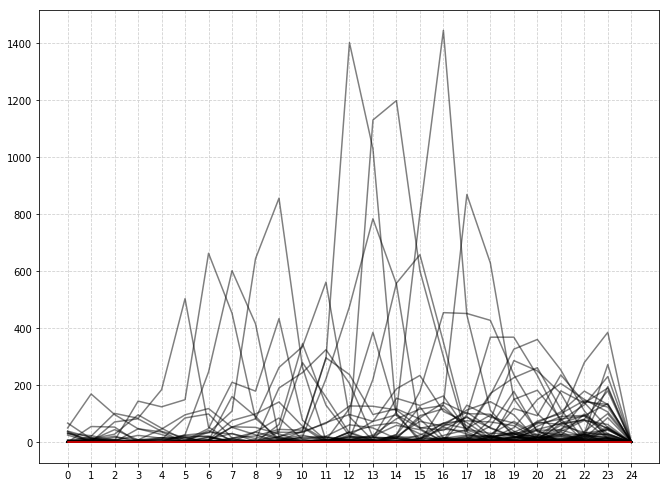

In [16]:
fig, ax = plt.subplots()

for index, row in time_series.iterrows():
    ax.plot(time_series.columns, row, color='#00000080', label=row.name)

ax.plot(time_series.columns, interval_median, color='red')

ax.yaxis.grid(color='#D0D0D0', linestyle='--')

ax.set_xticks(time_series.columns)
#for tick in ax.get_xticklabels():
#    tick.set_rotation(45)
    
ax.xaxis.grid(color='#D0D0D0', linestyle='--')

plt.show()

### Decluttered plot: Lightning strike count decentiles over time for all places
Instead of the lines for the individual cells, we shall plot the previously computed decentiles. For each time step, 11 values will be plotted: minimum, maximum, and 9 deciles. The values corresponding to the same statistic (minimum, maximum, n-th decile) in consecutive time steps are connected by lines. In this way, 11 polylines are constructed: minimum and maximum lines and 9 decile lines.
<br>To facilitate distinguishing between the lines corresponding to different deciles, we shall paint the areas between the decile lines in alternating light and dark shades of grey. The lines as such will not be explicitly drawn for reducing the display clutter.
<br>First, we build a plot including all statistics. Since the maximal values are much higher than the 9th deciles, we can only see the variation of the maximal value and cannot see the other statistics. Therefore, we construct another plot where the vertical dimension represents a smaller interval of attribute values, i.e., the maximal values are not shown but the lower values can be seen better.

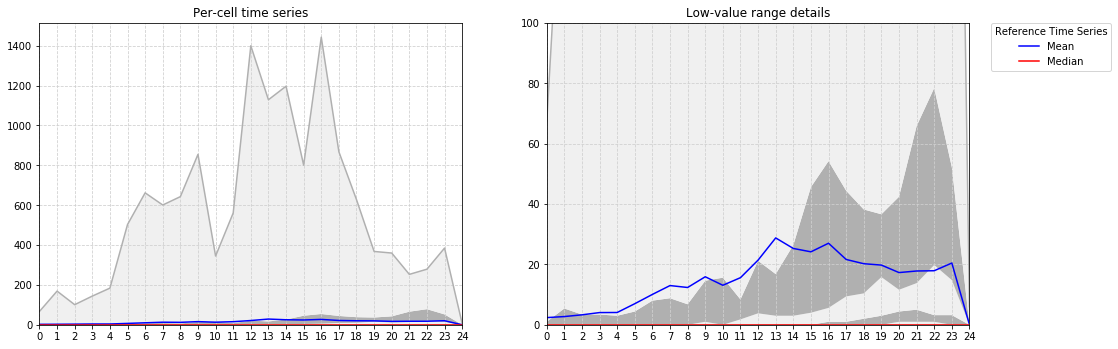

In [17]:
quant_color_dark  = '#B0B0B0FF'
quant_color_light = '#F0F0F0FF'
quant_range_colors = [quant_color_light, quant_color_dark]

fig, axs = plt.subplots(1, 2, figsize=(1200/screen_dpi,400/screen_dpi))

###### First (left) subplot
ax = axs[0]
for i in range(1, len(quantile_borders)):
    ax.fill_between(int_quantiles.index, int_quantiles[quantile_borders[i-1]], int_quantiles[quantile_borders[i]], facecolor=quant_range_colors[i%2])

ax.plot(interval_min.index, interval_min, color=quant_color_dark)
ax.plot(interval_max.index, interval_max, color=quant_color_dark)

legend_handles = [None, None] # Manually collect relevant legend handles, so we can suppress that every single (auto-labeled) decentile element gets crammed into the legend
legend_handles[0], = ax.plot(interval_mean.index, interval_mean, color='blue')
legend_handles[1], = ax.plot(interval_median.index, interval_median, color='red')

# Draw a subtle reference grid
ax.yaxis.grid(color='#D0D0D0', linestyle='--')
ax.xaxis.grid(color='#D0D0D0', linestyle='--')

# X-axis tick labels might need a little bit of help to look nicely
ax.set_xticks(int_quantiles.index)
#for i, tick in enumerate(ax.get_xticklabels()):
#    tick.set_label(str(int_quantiles.index))
#    tick.set_rotation(45)

ax.set_title('Per-cell time series')

ax.set_xlim(0, mod_steps)
ax.set_ylim(0)
    
###### Second (right) subplot
ax = axs[1]
for i in range(1, len(quantile_borders)):
    ax.fill_between(int_quantiles.index, int_quantiles[quantile_borders[i-1]], int_quantiles[quantile_borders[i]], facecolor=quant_range_colors[i%2])

ax.plot(interval_min.index, interval_min, color=quant_color_dark)
ax.plot(interval_max.index, interval_max, color=quant_color_dark)

legend_handles = [None, None] # Manually collect relevant legend handles, so we can suppress that every single (auto-labeled) decentile element gets crammed into the legend
legend_handles[0], = ax.plot(interval_mean.index, interval_mean, color='blue')
legend_handles[1], = ax.plot(interval_median.index, interval_median, color='red')

# Draw a subtle reference grid
ax.yaxis.grid(color='#D0D0D0', linestyle='--')
ax.xaxis.grid(color='#D0D0D0', linestyle='--')

# X-axis tick labels might need a little bit of help to look nicely
ax.set_xticks(int_quantiles.index)
#for i, tick in enumerate(ax.get_xticklabels()):
#    tick.set_label(str(int_quantiles.index))
#    tick.set_rotation(45)

ax.set_title('Low-value range details')

ax.set_xlim(0, mod_steps)
# Zoom the plot on the low values range for more details
ax.set_ylim(0, 100)

###### Joint legend
labels = ['Mean', 'Median']
ax.legend(handles=legend_handles, title='Reference Time Series', labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

### First geovisualization of max counts per grid cell over all time intervals

Depending on your task, data and their visual representation, different background maps need to be selected. See a menu of available styles at <a href=https://deparkes.co.uk/2016/06/10/folium-map-tiles/>https://deparkes.co.uk/2016/06/10/folium-map-tiles/</a>

In [18]:
# Make sure that the data to be bound will have an entry for each grid cell from the geometry object.
# Unfortunately, if a geometry has no matching data entry to bind, folium will default to the maximum value of the specified range (e.g., 1400 in the example below)
all_cell_ids = ['{:02d}_{:02d}'.format(c,r) for c in range(lon_cells) for r in range(lat_cells)]
max_counts = time_series.max(axis=1, skipna=True).reindex(index=all_cell_ids).fillna(0).astype(int)

max_counts.head()

cell_id
00_00    31
00_01     4
00_02    39
00_03     4
00_04     4
dtype: int32

In [19]:
# Set up the base map
m = fm.Map(tiles='cartodbdark_matter', width='100%', height='100%') # If you adjusted the notebook display width to be as wide as your screen, the map might get very big. Adjust size as desired.
m.fit_bounds([[lat_range[0], lon_range[0]], [lat_range[1], lon_range[1]]])

lon_incr = (lon_range[1] - lon_range[0]) / lon_cells
lat_incr = (lat_range[1] - lat_range[0]) / lat_cells

min_val = max_counts.min()
max_val = max_counts.max()

ncol = len(cb2_ordrd_rgb)
col_range = 1 / (ncol-1)

for c in range(lon_cells):
    for r in range(lat_cells):
        cell_id = '{:02d}_{:02d}'.format(c,r)
        
        val = max_counts[cell_id]
        nval = (val - min_val) / (max_val - min_val)
        
        center_x = lon_range[0] + (c + 0.5)*lon_incr
        center_y = lat_range[0] + (r + 0.5)*lat_incr
        
        # Determine interpolated color
        col_int = divmod(nval, col_range)
        ci = int(col_int[0])
        r = col_int[1] / col_range
        if (r > 0.0 and ci < ncol):
            c0 = cb2_ordrd_rgb[ci]
            c1 = cb2_ordrd_rgb[ci+1]
            col = (
                int((1.0-r)*c0[0] + r*c1[0]),
                int((1.0-r)*c0[1] + r*c1[1]),
                int((1.0-r)*c0[2] + r*c1[2])
            )
            c_string = '#{:02x}{:02x}{:02x}'.format(col[0], col[1], col[2])
        
        if (val > 0):
            fm.Circle((center_y, center_x), radius=8000, color=c_string, fill_color=c_string, fill=True, weight=0, fill_opacity=0.25+(nval*0.5), popup='Maximum count: {}'.format(val)).add_to(m)

m

### Apply projection by similarity to the time series in the grid cells
Multiple complex objects, such as time series or multi-attribute value combinations, can be explored using a 2D projection in which the objects are placed according to their similarities. The similarities are defined by means of a suitable distance function, such as Euclidean distance. One of possible uses of such a projection is to assign colours to the objects, so that these colours can be used in various displays. The idea is that similar items are located close to each other in the projection and therefore receive similar colours.

In [20]:
time_series.head()

interval,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
cell_id,,,,,,,,,,,,,,,,,,,,,,,,,
00_00,31,8,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00_01,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00_02,39,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00_03,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00_04,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### This function generates color according to a position in a projection

In [21]:
import math
def getColor (x, y, minX, maxX, minY, maxY):
    wX=maxX-minX 
    wY=maxY-minY
    rr=y-minY 
    cc=x-minX
    #print(x,y)
    if (wY < wX):   #scale vertically, i.e. modify rr
        rr *= wX/wY  
    else:           #scale horizontally, i.e. modify cc
        cc *= wY/wX
    maxD=max(wX,wY)
    rr1=maxD-rr
    cc1=maxD-cc
    #print(rr,cc,maxD,rr1,cc1)
    dc=[math.sqrt(rr*rr+cc*cc),math.sqrt(rr*rr+cc1*cc1),math.sqrt(rr1*rr1+cc*cc),math.sqrt(rr1*rr1+cc1*cc1)]
    weights=[0.0,0.0,0.0,0.0]
    for i in range(len(weights)):
        weights[i]=(maxD-dc[i])/maxD
        if (weights[i]<0):
            weights[i]=0
    #print(dc,weights)
    reds=[228,25,255,37]
    greens=[220,228,18,13]
    blues=[0,218,6,252]
    dr=0
    dg=0
    db=0
    for i,weight in enumerate(weights):
        dr += weight*reds[i]
        dg += weight*greens[i]
        db += weight*blues[i]
    if (dr<0):
        dr=0;
    if (dr>255):
        dr=255
    if (dg<0):
        dg=0;
    if (dg>255):
        dg=255        
    if (db<0):
        db=0;
    if (db>255):
        db=255  
    #print(weights,dr,dg,db)
    c_string = '#{:02x}{:02x}{:02x}'.format(int(dr),int(dg),int(db))    
    return c_string

### Now we make a projection of the time series by their similarities and assign colors to cells according to the positions in the projection.
The colours obtained in this way are used for painting the cells in a map.

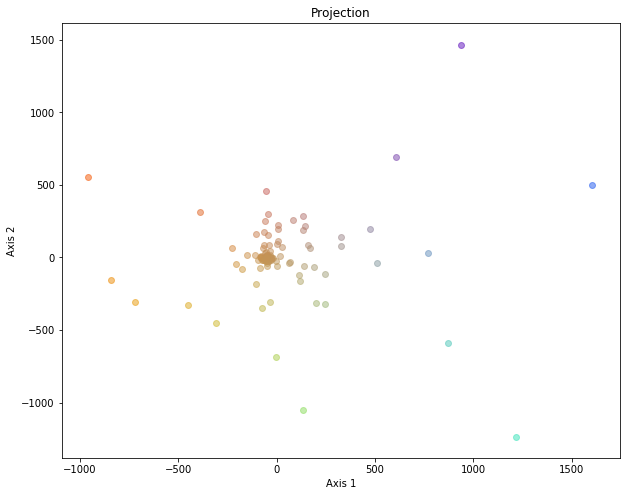

In [22]:
# Let's run a Principal Component Analysis 
#from sklearn.decomposition import PCA
#pca = PCA(n_components = 2)
#pca.fit(time_series)
#xy_pca = pca.transform(time_series)
#print('Explained variance ratio \n   Total :', round(pca.explained_variance_ratio_.sum()*100, 2), '%',
#      '\n   By principal component :', pca.explained_variance_ratio_, '\n');

# Let's run MDS
from sklearn.manifold import MDS
mds = MDS(n_components = 2, random_state=101)
mds.fit(time_series)
xy_pca = mds.fit_transform(time_series)

# Let us visualize the result in a scatter plot
plt.figure(figsize=(10,8))
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Projection')
colors = [(0,0,0)]
#plt.scatter(xy_pca[:,0], xy_pca[:,1], alpha = .5, c=colors)
for i in range(len(xy_pca)):
    plt.scatter(xy_pca[i,0], xy_pca[i,1], alpha = .5, c=getColor(xy_pca[i,0], xy_pca[i,1], xy_pca[:,0].min(), xy_pca[:,0].max(), xy_pca[:,1].min(), xy_pca[:,1].max()))

# Set up the base map
m = fm.Map(tiles='cartodbdark_matter', width='100%', height='100%') # If you adjusted the notebook display width to be as wide as your screen, the map might get very big. Adjust size as desired.
m.fit_bounds([[lat_range[0], lon_range[0]], [lat_range[1], lon_range[1]]])
lon_incr = (lon_range[1] - lon_range[0]) / lon_cells
lat_incr = (lat_range[1] - lat_range[0]) / lat_cells
i=0
for c in range(lon_cells):
    for r in range(lat_cells):
        cell_id = '{:02d}_{:02d}'.format(c,r)
        val = max_counts[cell_id]
        if (val>0):
            data = time_series.loc[cell_id]
            center_x = lon_range[0] + (c + 0.5)*lon_incr
            center_y = lat_range[0] + (r + 0.5)*lat_incr
            c_string=getColor(xy_pca[i,0], xy_pca[i,1], xy_pca[:,0].min(), xy_pca[:,0].max(), xy_pca[:,1].min(), xy_pca[:,1].max())
            fm.Circle((center_y, center_x), radius=8000, color=c_string, fill_color=c_string, fill=True, weight=1, fill_opacity=0.7, popup='Cell: {:02d}_{:02d}<br>proj_xy: {}, {}'.format(c,r,xy_pca[i,0],xy_pca[i,1])).add_to(m)
            i+=1

m

The projection and the colours on the map show that most of the cells have very similar time series, 
while there are quite a few cells whose time series significantly differ from all others.

## Perform clustering of grid cell time series

### Execute the cell below if you want to re-run the clustering, to reset the time series data
<b>Note:</b> In this code, colours are assigned to the clusters using one of the commonly used colour palettes recommended by Color Brewer; see http://colorbrewer2.org. The maximal number of distinct colours in a palette used for qualitative (categorical) values is 12; therefore, the code produces 12 clusters, and you can change it to a smaller number.
<br>To overcome the limitation posed by the colour palette, you can use the colour assignment function <i>getColor</i> defined earlier (cell [21]). For this purpose, you need to project the centroids of the clusters to 2D using MDS and then assign colours according to their positions in the same way as this was previously done for the individual geographic cells (notebook cell [22]). This will resolve the problem of limited colour scale and enable visual perception of cluster similarities based on their colours.

In [23]:
k = 12 # 12 is tthe upper limit for k, as ColorBrewer's color scale has 12 colors only.
# This unstack command retains the first level of our index (cell_id) and pivots the values of the target column (Count) into columns defined by values of the second index level ('interval', zero-based level index)
time_series = st_aggregates[target_col].unstack(level=1)

# Some cleanup - Reshaping will create null values in columns for empty groups (which here are our time intervals).
# For time series of lightning strike counts per time interval, replacing by 0 (no lightning strikes were registered) is appropriate.  Additionally, coerce to int after filling null values.
time_series = time_series.fillna(0).astype(int)
clust_id_col_name = 'Cluster ID (k={})'.format(k)

In [24]:
kmeans = KMeans(n_clusters=k, random_state=42)
clus = kmeans.fit(time_series)

time_series[clust_id_col_name] = clus.labels_

centroids = pd.DataFrame(data=clus.cluster_centers_, columns=time_series.drop(clust_id_col_name, axis=1).columns)
cluster_sizes = Counter(clus.labels_)
for cid, cnt in cluster_sizes.items():
    cluster_sizes[cid] = (cnt, log10(cnt) + 1)

In [25]:
# Make sure that the data to be bound will have an entry for each grid cell from the geometry object.
# Unfortunately, if a geometry has no matching data entry to bind, folium will default to the maximum value of the specified range
all_cell_ids = ['{:02d}_{:02d}'.format(c,r) for c in range(lon_cells) for r in range(lat_cells)]
time_series = time_series.reindex(index=all_cell_ids)
time_series[clust_id_col_name] = time_series[clust_id_col_name].fillna(k).astype(int)
time_series = time_series.fillna(0).astype(int)

In [26]:
# Set up the base map
m = fm.Map(tiles='cartodbdark_matter', width='100%', height='100%') # If you adjusted the notebook display width to be as wide as your screen, the map might get very big. Adjust size as desired.
m.fit_bounds([[lat_range[0], lon_range[0]], [lat_range[1], lon_range[1]]])

# m.choropleth(
#     grid,
#     data=time_series.reset_index(drop=False),
#     columns=['cell_id', clust_id_col_name],
#     key_on='feature.properties.id',
#     fill_color='Set1',
#     threshold_scale=[0, 1, 2, 3, 4, 5],
#     legend_name='Maximum event count over time intervals',
#     highlight=False
# )

lon_incr = (lon_range[1] - lon_range[0]) / lon_cells
lat_incr = (lat_range[1] - lat_range[0]) / lat_cells

for c in range(lon_cells):
    for r in range(lat_cells):
        cell_id = '{:02d}_{:02d}'.format(c,r)
        data = time_series.loc[cell_id]
        center_x = lon_range[0] + (c + 0.5)*lon_incr
        center_y = lat_range[0] + (r + 0.5)*lat_incr
        cluster_id = data[clust_id_col_name]
        if (cluster_id < k):
            fm.Circle((center_y, center_x), radius=8000, weight=1, color=clust_colors[cluster_id], fill_color=clust_colors[cluster_id], fill=True, fill_opacity=0.7, popup='Cell: {}_{}; Cluster: {}'.format(c,r,cluster_id)).add_to(m)

m

### Plot temporal dynamics of obtained clusters

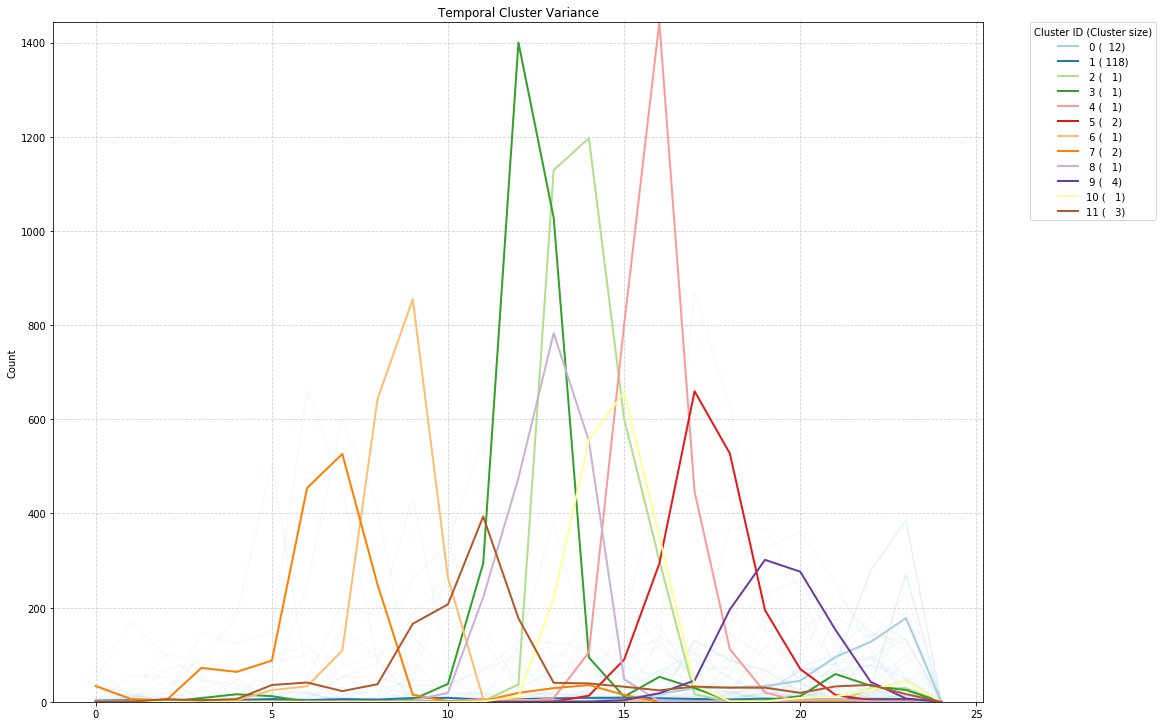

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(1200/screen_dpi, 900/screen_dpi)

# Select subset of clusters for detail comparison
#selected_clusters = [0, 3, 5]
# or use the next statement to display all clusters simultaneously
selected_clusters = [x for x in range(k)]

x_vals = [x for x in range(mod_steps+1)]
for index, row in time_series.iterrows():
    cluster_id = row[mod_steps]
    if (cluster_id < k and cluster_id in selected_clusters):
        ax.plot(x_vals, row[0:mod_steps+1], color=clust_colors[cluster_id], alpha= 0.1, label=index)

legend_handles = [] # Manually collect relevant legend handles, so we can suppress that every single cell's label gets crammed into the legend
for cluster_id, centroid in centroids.iterrows():
    if (cluster_id in selected_clusters):
        centroid_handle, = ax.plot(centroid.index, centroid, color=clust_colors[cluster_id], alpha= 1.0, linewidth=2, label=cluster_id)
        legend_handles.append(centroid_handle)

ax.set_ylabel(target_col)
ax.yaxis.grid(color='#D0D0D0', linestyle='--')
ax.xaxis.grid(color='#D0D0D0', linestyle='--')

ax.set_ylim(0, max_val)

plt.title('Temporal Cluster Variance')

labels = [None] * len(selected_clusters)
for i, cid in enumerate(selected_clusters):
    labels[i] = '{:>2} ({:>4})'.format(cid, cluster_sizes[cid][0])

plt.legend(handles=legend_handles, title='Cluster ID (Cluster size)', labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

# Space-in-time: considering the data as temporal variation of spatial distributions

So far, we considered and analysed the data as a spatial distribution of local time series. A complementary view is to see the data as temporal variation of the spatial distributions of the values per time step. To see the data from this perspective, we transpose the table.

### Let's transpose the table with aggregates

In [28]:
ttime_series=time_series.T
ttime_series.head()

cell_id,00_00,00_01,00_02,00_03,00_04,00_05,00_06,00_07,00_08,00_09,00_10,00_11,00_12,01_00,01_01,01_02,01_03,01_04,01_05,01_06,01_07,01_08,01_09,01_10,01_11,01_12,02_00,02_01,02_02,02_03,02_04,02_05,02_06,02_07,02_08,02_09,02_10,02_11,02_12,03_00,03_01,03_02,03_03,03_04,03_05,03_06,03_07,03_08,03_09,03_10,03_11,03_12,04_00,04_01,04_02,04_03,04_04,04_05,04_06,04_07,04_08,04_09,04_10,04_11,04_12,05_00,05_01,05_02,05_03,05_04,05_05,05_06,05_07,05_08,05_09,05_10,05_11,05_12,06_00,06_01,06_02,06_03,06_04,06_05,06_06,06_07,06_08,06_09,06_10,06_11,06_12,07_00,07_01,07_02,07_03,07_04,07_05,07_06,07_07,07_08,07_09,07_10,07_11,07_12,08_00,08_01,08_02,08_03,08_04,08_05,08_06,08_07,08_08,08_09,08_10,08_11,08_12,09_00,09_01,09_02,09_03,09_04,09_05,09_06,09_07,09_08,09_09,09_10,09_11,09_12,10_00,10_01,10_02,10_03,10_04,10_05,10_06,10_07,10_08,10_09,10_10,10_11,10_12,11_00,11_01,11_02,11_03,11_04,11_05,11_06,11_07,11_08,11_09,11_10,11_11,11_12,12_00,12_01,12_02,12_03,12_04,12_05,12_06,12_07,12_08,12_09,12_10,12_11,12_12,13_00,13_01,13_02,13_03,13_04,13_05,13_06,13_07,13_08,13_09,13_10,13_11,13_12,14_00,14_01,14_02,14_03,14_04,14_05,14_06,14_07,14_08,14_09,14_10,14_11,14_12
interval,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,31,0,39,4,4,38,34,5,6,0,0,0,0,0,0,7,50,0,0,1,0,0,1,0,0,0,7,0,0,25,1,0,0,0,0,0,0,0,0,30,0,0,0,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,0,16,1,0,0,0,4,5,0,0,0,0,8,0,16,169,55,0,6,12,2,0,0,0,0,2,0,0,1,21,0,0,0,0,0,0,0,0,23,0,11,0,12,4,0,0,0,0,0,0,0,0,0,6,0,7,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,21,0,0,0,1,0,1,0,5,0,0,0,0,3,7,1,97,53,0,0,9,9,0,0,0,0,0,0,0,71,101,1,0,0,0,0,0,0,0,6,0,0,0,6,0,0,0,0,0,0,0,0,0,0,4,0,44,28,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,4,0,0,0,0,0,0,0,0,0,0,0,1,24,1,47,0,2,1,0,3,2,0,0,0,0,0,2,82,84,47,0,6,6,5,1,0,0,0,0,0,0,144,8,0,0,0,0,0,0,0,0,0,3,0,8,96,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,36,0,0,0,0,0,0,0,0,0,0,0,16,38,184,27,1,1,8,10,0,0,0,0,0,3,3,124,46,0,0,0,0,0,0,0,0,2,0,3,0,49,0,0,0,0,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,0,0,0,0,0,0,16,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### We shall look at similarities of the time intervals in terms of the spatial distributions by projecting the distributions to 2D space
The spatial distributions are represented by the combinations of the per-cell values. The evolution of the spatial distribution (corresponding to the evolution of the thunderstorm in our example) can be represented as a "trajectory" in a projection space. The trajectory is obtained by connecting the points corresponding to consecutive time steps.
<br>We shall first build a projection using PCA and then try another projection algorithm.

In [29]:
from sklearn.decomposition import PCA

# Let's run a Principal Component Analysis 
pca = PCA(n_components = 2)
pca.fit(ttime_series[0:mod_steps])
tts_pca = pca.transform(ttime_series)
print('Explained variance ratio \n   Total :', round(pca.explained_variance_ratio_.sum()*100, 2), '%',
      '\n   By principal component :', pca.explained_variance_ratio_, '\n');

Explained variance ratio 
   Total : 52.89 % 
   By principal component : [0.30449846 0.22438491] 



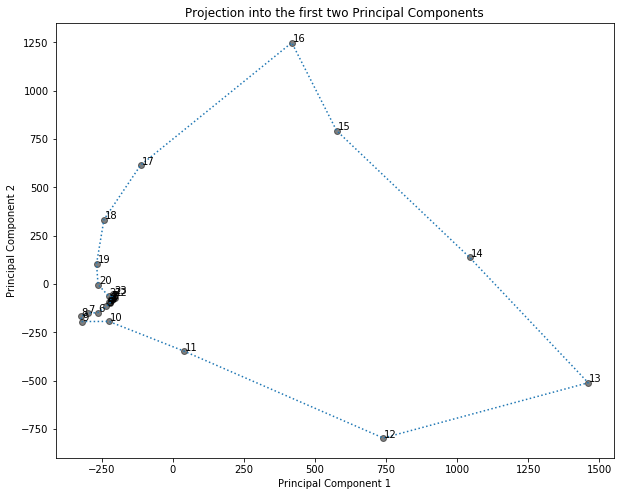

In [30]:
# Let us visualize the result in a scatter plot
plt.figure(figsize=(10,8))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projection into the first two Principal Components')
colors = [(0,0,0)]
plt.scatter(tts_pca[:,0], tts_pca[:,1], alpha = .5, c=colors)
for i in np.arange(mod_steps):
    plt.text(tts_pca[i,0]+3, tts_pca[i,1]+3, '{0}'.format(i))
plt.plot(tts_pca[:,0],tts_pca[:,1], linestyle=':')   

The PCA projection has a lot of over-plotting, i.e., multiple points put in the same or almost the same place. To make the representation clearer, we shall try another projection algorithm.

### We can try a different projection by MDS

In [31]:
from sklearn.manifold import MDS

# Let's run MDS
mds = MDS(n_components = 2, random_state=111)
mds.fit(ttime_series[0:mod_steps])
tts_mds = mds.fit_transform(ttime_series[0:mod_steps])

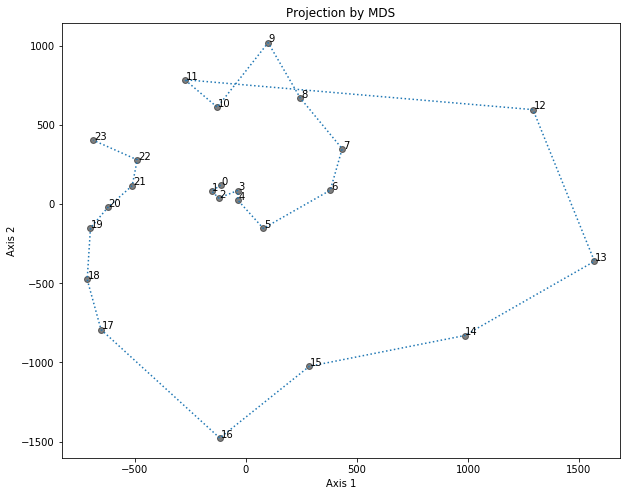

In [32]:
# Let us visualize the result in a scatter plot
plt.figure(figsize=(10,8))
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Projection by MDS')
colors = [(0,0,0)]
plt.scatter(tts_mds[:,0], tts_mds[:,1], alpha = .5, c=colors)
for i in np.arange(mod_steps):
    plt.text(tts_mds[i,0]+3, tts_mds[i,1]+3, '{0}'.format(i))
plt.plot(tts_mds[:,0],tts_mds[:,1], linestyle=':')        

The projection by MDS gives a clearer result with less over-plotting. Please note that large distances between consecutive positions of the trajectory mean large changes in the distribution, whereas small distances signify small changes. So, we see that there were almost no changes in the initial time steps, then, starting from step 5, the situation changed more and more. The largest change happened from step 11 to step 12. At the end, the changes were small again, and the situation was similar to that in the beginning. The most significant changes happened in the interval from step 11 to step 17, and the situations in the steps from 12 to 16 were very dissimilar to all others and also between themselves. 

## We suggest you to do on your own:

- Regarding the projection of the time steps: calculate "average distributions" (i.e., average per-cell values) for different periods that can be identified in the projection, e.g., the initial period with very small changes, period from step 8 to step 11, which are relatively close in the projection, and final period of small changes. Visualise the aggregates (i.e., the average distributions) on maps and compare them. Please note that it is not reasonable to make aggregates from objects that are distant in the projection space. The aggregates obtained from similar distribution states can be compared to individual states that are dissimilar from all others.
- Regarding the clustering, assign colours to clusters based on their similarity. For this purpose you need to project the centroids of the clusters to 2D using MDS and then assign colours according to their positions using the function defined in the current notebook. This will resolve the problem of limited colour scale and enable visual perception of cluster similarities based on their colours.
- The notebook includes clustering of the cells according to their time series of event counts, which may be called <b>time-in-space clustering</b>. Try also <b>space-in-time clustering</b>, i.e., cluster the time steps according to the feature vectors representing the counts of the events in the cells. For this purpose, clustering is applied to the transposed table <i>ttime_series</i> obtained in cell [28]. This is done in the same way as the clustering of the original table. 
 - Visualize the centroids of the clusters (i.e., averaged per-cell values) in maps. Compare the clusters by subtracting their centroids and displaying difference maps.
- For both time-in-space and space-in-time clustering, analyse the sensitivity of the results to the parameters and examine the similarity of the cluster members to the centroids. For this purpose, for example, start with looking at frequency histograms of the distances to the centroids. 
